# Water Quality: Data Wrangle

In [81]:
import pandas as pd
import geopandas as gpd
import geopy
import re
import matplotlib.pyplot as plt
from string import punctuation
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim

## 1. Preliminary Data Cleaning

In [82]:
wdf = pd.read_excel('data/water_qual.xlsx', header=2, sheet_name='Initial', 
                    usecols=[0, 1, 2, 3, 4], skipfooter=6, 
                    dtype={'1st Draw':"str", '2-3 Minute': 'str', '5 Minute': 'str'})
wdf.head(3)

,Date Sampled,Address,1st Draw,2-3 Minute,5 Minute
0,2020-01-26 07:42:00,X N Bishop St,<1.0,<1.0,<1.0
1,2016-11-08 05:30:00,XX N Lasalle St,<1,<1,<1
2,2019-11-07 06:18:00,X W Brayton St,<1.0,6.9,<1.0


In [83]:
# Sequential data
wdf_s = pd.read_excel('data/water_qual.xlsx', header=2, sheet_name='Sequential', 
                    usecols=[0, 1, 2, 12, 13], skipfooter=6, 
                    dtype={'1st Draw':"str", '3 Minute': 'str', '5 Minute': 'str'})

In [84]:
# Data Exploration and Cleaning
print(f'Date ranges for data are: {wdf["Date Sampled"].min().date()} to {wdf["Date Sampled"].max().date()}')
print(f'There are {wdf.shape[0]:,} observations in the dataset.')

# Replace any "<1.0" or similar with 1.0
wdf.replace(to_replace="^<\s?[01]\.?.*", value="1.0", inplace=True, regex=True)

wdf.dropna(subset=["1st Draw"], inplace=True)

# Remove observations that merely state a residence has been referred to addl. testing
wdf.drop(wdf[wdf['1st Draw'].str.contains("^\D", regex=True)].index.values, inplace=True)

# Convert to float
wdf.loc[:, '1st Draw': '5 Minute'] = (wdf.loc[:,'1st Draw':'5 Minute'].astype('float64'))

# Replace any observations that were float <1.0 with 1.0. 
wdf.loc[:,'1st Draw':'5 Minute'] = (wdf.loc[:,'1st Draw':'5 Minute']
    .mask(wdf.loc[:,'1st Draw':'5 Minute'] < 1, other=1.0))

Date ranges for data are: 2016-01-27 to 2021-01-07
There are 23,882 observations in the dataset.


In [85]:
print('Summary statistics for the 1st sample drawn in initial testing:')
print(wdf['1st Draw'].describe())
print()
print('Summary statistics for the 2nd sample (2-3 Minute Mark) drawn in initial testing:')
print(wdf['2-3 Minute'].describe())
print()
print('Summary statistics for the final sample (5 Minute Mark) drawn in initial testing:')
print(wdf['5 Minute'].describe())

wdf["Threshold"] = (wdf.loc[:,'1st Draw':'5 Minute'] >= 15).any(axis=1)
print()
print(f'A total of {wdf["Threshold"].sum():,} (' + 
      f'{round(wdf["Threshold"].sum() / wdf.shape[0] * 100, 2)}' + 
      f'%) observations had at least one ')
print(f'water sample test containing 15.0 or more lead parts per billion (ppb) in initial testing.')

Summary statistics for the 1st sample drawn in initial testing:
count    22668.000000
mean         3.640967
std         13.724032
min          1.000000
25%          1.000000
50%          2.000000
75%          3.800000
max        730.000000
Name: 1st Draw, dtype: float64

Summary statistics for the 2nd sample (2-3 Minute Mark) drawn in initial testing:
count    22667.000000
mean         4.112260
std          6.835936
min          1.000000
25%          1.000000
50%          2.200000
75%          5.400000
max        460.000000
Name: 2-3 Minute, dtype: float64

Summary statistics for the final sample (5 Minute Mark) drawn in initial testing:
count    22667.000000
mean         2.267388
std          3.051567
min          1.000000
25%          1.000000
50%          1.200000
75%          2.500000
max        240.000000
Name: 5 Minute, dtype: float64

A total of 1,007 (4.44%) observations had at least one 
water sample test containing 15.0 or more lead parts per billion (ppb) in initial testing.

In [86]:
# Cleaning addresses for geocoding
wdf.Address.replace({'^XX\s': '10 ', '^X\s': '1 ', 
                     'XX':'00', '[0-9]X':'0'}, regex=True, inplace=True)
wdf.Address = wdf.Address.str.strip(punctuation)
wdf.Address += ', Chicago, IL, USA'

In [87]:
# Geocoding Addresses

# Geocoding the +20,000 observations takes substantially long. Please load
# the data/wdf_points.csv to continue working with the geocoded dataset.

# locator = Nominatim(user_agent="myGeocoder")
# location = locator.geocode("Chicago, IL, USA")

# geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# wdf['location'] = wdf['Address'].apply(geocode)
# wdf['point'] = wdf['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# wdf[['latitude', 'longitude', 'altitude']] = pd.DataFrame(wdf['point'].tolist(), index=wdf.index)
# wdf.drop('altitude', 'point', axis=1, inplace=True)

# wdf.to_csv('data/wdf_points.csv')

<AxesSubplot:>

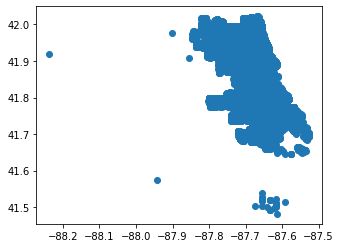

In [88]:
# Converting to geopandas df 
wdf = pd.read_csv('data/wdf_points.csv', index_col=[0])

# Manually cleaning some obs
wdf.loc[wdf["Address"] == "1800 W Chicago Ave , Chicago, IL, USA", ["longitude"]] = -87.67228848673774
wdf.loc[wdf["Address"] == "1800 W Chicago Ave , Chicago, IL, USA", ["latitude"]] = 41.896391737686976
wdf.loc[wdf["Address"] == "1100 W 17th St, Chicago, IL, USA", ["longitude"]] = -87.65310150616693
wdf.loc[wdf["Address"] == "1100 W 17th St, Chicago, IL, USA", ["latitude"]] = 41.862919274995626
wdf.loc[wdf["Address"] == "1600 N 18th St , Chicago, IL, USA", ["longitude"]] = -87.85520742698857
wdf.loc[wdf["Address"] == "1600 N 18th St , Chicago, IL, USA", ["latitude"]] = 41.906865692166896
wdf.loc[wdf["Address"] == "2400 W Harrison Ave, Chicago, IL, USA", ["longitude"]] = -87.68634655975251
wdf.loc[wdf["Address"] == "2400 W Harrison Ave, Chicago, IL, USA", ["latitude"]] = 41.87425757200666
wdf.loc[wdf["Address"] == "800 N Elizabeth St , Chicago, IL, USA", ["longitude"]] = -87.65992222906638
wdf.loc[wdf["Address"] == "800 N Elizabeth St , Chicago, IL, USA", ["latitude"]] = 41.89661964867207

wdf_g = gpd.GeoDataFrame(
    wdf, geometry=gpd.points_from_xy(wdf.longitude, wdf.latitude))
wdf_g.plot()

In [89]:
print(f' There are {wdf_g.latitude.isna().sum()} observations with missing coordinates.')

 There are 585 observations with missing coordinates.


In [104]:
wdf_g.to_file("water_quality_clean.shp")

<ipython-input-104-c267fcc130c4>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  wdf_g.to_file("water_quality_clean.shp")
